<a href="https://colab.research.google.com/github/snaby/project2/blob/master/project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Functions for Numerical Diagonalization

In [ ]:
# import cell
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import unitary_group

# Functions for Later Use

Below we define the functions that make up the code to numerically diagonalize Hermitian matrices. We begin with a function jacobi_rotation which applies a Jacobi rotation to input real symmetric matrix A and computes the orthogonal matrix J which makes the (k, j) element of A vanish under a similarity transformation. 

In order to compute how "non-diagonal" the matrix is at any given point we then define the function off which takes a matrix A and computes the sum 
$$ off(A) = \sqrt{\sum_{i\neq j} |A_{ij}|^2}$$

The next function is real_eigen which uses jacobi_rotation and off in order to diagonalize a real symmetric matrix to a given tolerance. It does this by looping through the off-diagonal elements of A, determing the Jacobi rotation necessary to make each element vanish until the sum returned by off is smaller than the tolerance times the Froebenius norm of the matrix. 

Finally, we define the function complex_eigen which takes a Hermitian matrix, splits it into its real and imaginary parts, and forms a real symmetric matrix from those parts which can then be diagonalized using real_eigen from which the eigenvalues and vectors of the original Hermitian matrix are reconstructed. 

Finally, the function hermitian_eigensystem calls complex_eigen and orders the array of eigenvalues and vectors in non-decreasing order. 

In [ ]:
#difficulty: ★★★
def jacobi_rotation(A, j, k):
    #Args:
        # A (np.ndarray): n by n real symmetric matrix
        # j (int): column parameter.
        # k (int): row parameter.

    #Returns:
        # A (np.ndarray): n by n real symmetric matrix, where the A[j,k] and A[k,j] element is zero
        # J (np.ndarray): n by n orthogonal matrix, the jacobi_rotation matrix
    if A[k, j] != 0:
      tau = (A[j, j] - A[k, k])/(2*A[k, j])
      if tau >= 0:
        t = 1/(tau + np.sqrt(1+tau**2))
      else:
        t = 1/(tau - np.sqrt(1+tau**2))
      
      c = 1/np.sqrt(1+t**2)
      s = t * c
    else:
      c = 1
      s = 0
    
    J = np.identity(A.shape[0], dtype=np.complex)
    J[j, j] = c
    J[k, j] = s
    J[j, k] = -s
    J[k, k] = c
    
    A = np.matmul(J.T, np.matmul(A, J))

    return A, J

#difficulty: ★
def off(A):
    # see above where the "off" function is defined
    sum_variable = 0
    for j in range(A.shape[0]):
      for k in range(j+1, A.shape[0]):
        sum_variable += 2*A[k, j]**2

    return np.sqrt(sum_variable)

#difficulty: ★★★
def real_eigen(A, tolerance):
    #Args:
        # A (np.ndarray): n by n real symmetric matrix
        # tolerance (float): the relative precision
    #Returns:
        # d (np.ndarray): n by 1 vector, d[i] is the i-th eigenvalue
        # R (np.ndarray): n by n orthogonal matrix, R[:,i] is the i-th eigenvector
        
    # call jacobi_rotation(A, j, k) iteratively
    # call off and norm to check if we can stop the iteration
    # off (you write it)
    # norm https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.norm.html
    Jtot = np.identity(A.shape[0], dtype=np.complex)
    norm = np.linalg.norm(A, ord='fro')
    while off(A) >= tolerance * norm:
        for j in range(A.shape[0]):
          for k in range(j+1, A.shape[0]):
            A, J = jacobi_rotation(A, j, k)
            Jtot = np.matmul(Jtot, J)
 
    d = np.array([A[i, i] for i in range(A.shape[0])])            
    idx = np.argsort(d)

    d = d[idx]
    R = Jtot[:, idx]

    return d, R

#difficulty: ★★
def complex_eigen(H, tolerance):
    #Args:
        # A (np.ndarray): n by n real hermitian matrix
        # tolerance (float): the relative precision
    #Returns:
        # d (np.ndarray): n by 1 vector, d[i] is the i-th eigenvalue
        # U (np.ndarray): n by n unitary matrix, U[i,:] is the i-th eigenvector
        
    #(1) split H=S+iA to real and imaginary parts
    #(2) construct a 2n by 2n real matrix B
    #(3) call dd, R = real_eigen(B,tolerance)
    #(4) organize the output of dd, R  to get d and U
    real=0.5*(H+np.conj(H))    
    imag=(H-np.conj(H))*(-0.5j)
    B=np.block([[real,-imag],[imag,real]])
    dd, R=real_eigen(B,tolerance)
    d=dd[::2]
    R=R[:,::2]
    U=R[:H.shape[0]]+1j*R[H.shape[0]:]
    return d, U

#difficulty: ★
def hermitian_eigensystem(H,tolerance):
    
    # call complex_eigen(H,tolerance)
    # rearrange d and U, so that they are in the non-decreasing order of eigenvalues
    d,U=complex_eigen(H,tolerance)
    idx = np.argsort(d)

    d = d[idx]
    U = U[:, idx]
    return d, U

# Code Test

For the code below, we first generated a 30 x 30 zero matrix. We used a random generator to generate a list of known eigenvalues. We filled the diagonal of our zero matrix with these eigenvalues. We then generated a unitary matrix and rotated the inital matrix using the unitary matrix to generate a random hermitian matrix with known eigenvalues and eigenvectors. We ran our function on that matrix, and checked that the eigenvalues match those that we previously generated using numpy.allclose and then checked that these eigenvalues solve the eigenvalue equation with our computed eigenvectors again using numpy.allclose to the tolerance specified in our function call (1e-8). 


In [ ]:
a=np.zeros((30,30))
eigenvalues=np.random.rand(30)
np.fill_diagonal(a,eigenvalues)

unitary=unitary_group.rvs(30)
matrixtest=np.matmul(np.conj(unitary.T),np.matmul(a,unitary))

d,U=hermitian_eigensystem(matrixtest,1e-8)

idxd = np.argsort(eigenvalues)
matrixtest_sorted = matrixtest[:,idxd]

idx = np.argsort(eigenvalues)
eigenvalues = eigenvalues[idx]
R = unitary[:, idx]

print("Eigenvalues Match?: ",np.allclose(eigenvalues, d))
print("Eigenvectors Match?:", np.allclose(matrixtest@U-d*U, np.zeros_like(unitary)))

Eigenvalues Match?:  True
Eigenvectors Match?: True


# Analysis of the Quantum Anharmonic Oscillator

We consider here a Hamiltonian of the form
$$ H = \frac{1}{2}(\hat{x}^2+\hat{p}^2)+\lambda \hat{x}^4$$
We will work in the basis $|n\rangle$ which is the set of eigenvectors of the harmonic oscillator problem. We first need to state the matrix elements of the new perturbing term.

1). We can write the position operator in terms of the raising and lowering operators 
$$ \hat{x} = \sqrt{\frac{\hbar}{2m\omega}}\left(\hat{a}+\hat{a}^\dagger\right)$$
Setting $\hbar$=1, $m=1$, and $\omega=1$, the position operator reduces to 
$$ \hat{x} = \sqrt\frac{1}{2}\left(\hat{a}+\hat{a}^\dagger\right)$$
Recall that 
\begin{align}
  \hat{a}|n\rangle &= \sqrt{n}|n-1\rangle\\
  \hat{a}^\dagger |n\rangle &= \sqrt{n+1}|n+1\rangle
\end{align}
and $\langle n|m\rangle=\delta_{nm}$. In this case,
\begin{align}
\langle n|\hat{x}^{2}|m\rangle&=\frac{1}{2}\langle n|\hat{a}^2+\hat{a}\hat{a}^\dagger +\hat{a}^\dagger \hat{a}+\left(\hat{a}^\dagger\right)^2|m\rangle \\
&= \frac{1}{2}\left[ \sqrt{m(m-1)}\delta_{n,m-2}+(2m+1)\delta_{nm}+\sqrt{(m+1)(m+2)}\delta_{n,m+2} \right]\\
&= \frac{1}{2}\left[\sqrt{(n+1)(n+2)}\delta_{n,m-2}+(1+2n)\delta_{n,m}+\sqrt{n(n-1)}\delta_{n,m+2}\right]\\
&= \frac{1}{2}\sqrt{(n+1)(n+2)}\delta_{n,m-2}+(n+1/2)\delta_{n,m}+\frac{1}{2}\sqrt{n(n-1)}\delta_{n,m+2}
\end{align}

We will now repeat the same process for 
$\langle n|\hat{x}^{4}|m\rangle$.
\begin{align}
(\hat{a}+\hat{a}^\dagger)^4|m\rangle&= (\hat{a}+\hat{a}^\dagger)(\hat{a}+\hat{a}^\dagger)(\hat{a}+\hat{a}^\dagger)(\hat{a}+\hat{a}^\dagger)m\rangle\\
&= (\hat{a})^4+ \hat{a}\hat{a}^\dagger\hat{a}^2+\hat{a}^\dagger\hat{a}^3+(\hat{a}^\dagger)^2\hat{a}^2+\hat{a}^2\hat{a}^\dagger\hat{a}+\hat{a}(\hat{a}^\dagger)^2\hat{a}+\hat{a}^\dagger\hat{a}\hat{a}^\dagger\hat{a}\;+ \nonumber\\
& + (\hat{a}^\dagger)^3\hat{a}+(\hat{a})^3\hat{a}^\dagger+\hat{a}\hat{a}^\dagger\hat{a}\hat{a}^\dagger+\hat{a}^\dagger(\hat{a})^2\hat{a}^\dagger+(\hat{a}^\dagger)^2\hat{a}\hat{a}^\dagger+(\hat{a})^2(\hat{a}^\dagger)^2\;+ \nonumber\\ & +\hat{a}(\hat{a}^\dagger)^3+\hat{a}^\dagger\hat{a}(\hat{a}^\dagger)^2+(\hat{a}^\dagger)^4|m\rangle
\end{align}

We evaluate these terms via the same rules used above, e.g.
\begin{align}
(\hat{a}^\dagger)^4|m\rangle &= \sqrt{(m+1)}(\hat{a}^\dagger)^3|m+1\rangle\\
&= \sqrt{(m+1)(m+2)}(\hat{a}^\dagger)^2|m+2\rangle\\
&= \sqrt{(m+1)(m+2)(m+3)}\hat{a}^\dagger|m+3\rangle\\
&= \sqrt{(m+1)(m+2)(m+3)(m+4)}|m+4\rangle\\
\langle n|(\hat{a}^\dagger)^4|m\rangle &= \sqrt{(m+1)(m+2)(m+3)(m+4)}\,\delta_{n,m+4}\\
&= \sqrt{(n-3)(n-2)(n-1)n}\,\delta_{n,m+4}\\
\end{align}
Evaluating all terms this way we get
\begin{align}
\langle n|\hat x^4|m\rangle 
    &= \tfrac{1}{4}\!\left(6n^2 + 6n + 3\right)\!\delta_{nm}
+ \sqrt{(n+1)(n+2)}\left(n+\tfrac{3}{2}\right)\!\delta_{n,m-2}\;+ \nonumber\\
& + \sqrt{(n-1)n\,}\left(n-\tfrac{1}{2}\right)\!\delta_{n,m+2} +
\tfrac{1}{4}\sqrt{(n+1)(n+2)(n+3)(n+4)}\,\delta_{n,m-4}\;+ \nonumber\\
& + \tfrac{1}{4}\sqrt{(n-3)(n-2)(n-1)n\,}\,\delta_{n,m+4}.
\end{align}

# 2.) Solving the Anharmonic Oscillator Problem

In the code cell below we make the basic framework for solving the anharmonic oscillator problem. We define a function harmonicosc which takes arguments n and lam and returns the n x n matrix whose elements are 
$$ (H_0+\lambda x^4)_{nm} = H_{0nm}+\lambda\langle n|x^4|m\rangle$$
according to the computations in the cell above where $H_0$ is the hamiltonian of the normal harmonic oscillator. In this cell we do an example of a 20 x 20 matrix with $\lambda=1$. The basis functions of the harmonic oscillator are defined using the function base_eigenfunction and the corresponding eigenfunctions of the anharmonic oscillator are computed for a given solution U of the eigenvalue equation in anharmonic_eigenfunction. We plot as an example the first excited state probability density for this case. 

Text(0.5, 1.0, '$|\\psi(x)|^2$ for First Excited State with $\\lambda=1$')

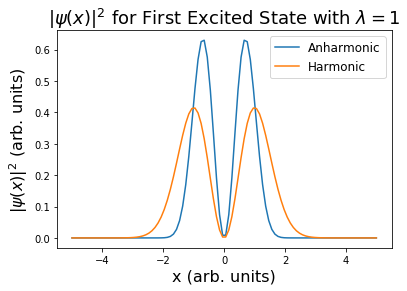

In [ ]:
def harmonicosc(n,lam):
  H0=np.identity(n, dtype=np.complex)
  for i in range(n):
    H0[i,i]=(i+0.5)
  Hprime=np.identity(n, dtype=np.complex)
  for i in range(n):
    for j in range(n):
      if i==j:
        Hprime[i,j]=0.25*lam*(6*i**2+6*i+3)
      elif i==j-2:
        Hprime[i,j]=lam*np.sqrt((i+1)*(i+2))*(i+1.5)
      elif i==j+2:
        Hprime[i,j]=lam*np.sqrt((i-1)*i)*(i-0.5)
      elif i==j-4:
        Hprime[i,j]=0.25*lam*np.sqrt((i+1)*(i+2)*(i+3)*(i+4))
      elif i==j+4:
        Hprime[i,j]=0.25*lam*np.sqrt((i-3)*(i-2)*(i-1)*i)
  return H0+Hprime

Hmat = harmonicosc(20, 1)
d,U=hermitian_eigensystem(Hmat,1e-8)

#print(d)
#print(U)

def base_eigenfunction(x, n):
  return (2**n*np.math.factorial(n)*np.sqrt(np.pi))**(-0.5)*np.exp(-x**2/2)*np.polynomial.hermite.hermval(x, np.array([0 for i in range(n)]+[1]))

def anharmonic_eigenfunction(x, n, U):
  coeffs = U[:,n]
  return np.sum(coeffs*np.array([base_eigenfunction(x, i) for i in range(len(coeffs))]))

anharmonic_eigenfunction = np.vectorize(anharmonic_eigenfunction, excluded=[2])

xarr = np.linspace(-5, 5, 100)

fig, ax = plt.subplots()
ax.plot(xarr, np.abs(anharmonic_eigenfunction(xarr, 1, U))**2)
ax.plot(xarr, np.abs(base_eigenfunction(xarr, 1))**2)
ax.legend(['Anharmonic', 'Harmonic'], fontsize=12)
ax.set_xlabel('x (arb. units)', fontsize=16)
ax.set_ylabel('$|\psi(x)|^2$ (arb. units)', fontsize=16)
ax.set_title('$|\psi(x)|^2$ for First Excited State with $\lambda=1$', fontsize=18)

#3) Plot of the First Four Energy levels $E_n$$(\lambda)$ versus $\lambda$ over the range 0$\leq$$\lambda$$\leq$1, and the Energy Differences

In the code cell below, we defined a function energy_vals which takes n and lam as its inputs and outputs our energy eigenvalues, d. We then plotted our first four energy eigenvalues over our range of $\lambda$. We then plotted the spacings between the energy levels $\Delta$E$_n$($\lambda$)=$E_{n+1}(\lambda)-E_n(\lambda)$. From this plot, you can see that spacing between the energy levels increases as the energy increases. 

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


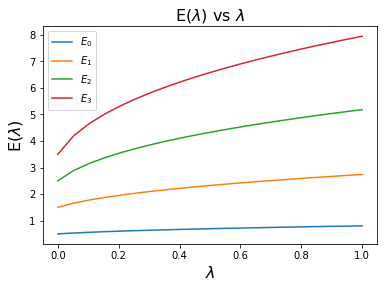

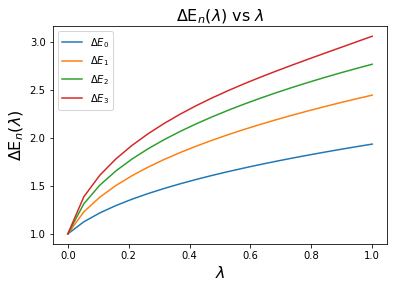

In [ ]:
def energyvals(n,lam):
  Hmat = harmonicosc(n,lam)
  d,U=hermitian_eigensystem(Hmat,1e-8)  
  return d 
energyvals=np.vectorize(energyvals)
lamrange=np.linspace(0,1,20)

darray = np.array([energyvals(20, lam) for lam in lamrange])

for i in range(4):
  plt.plot(lamrange, darray[:,i])
plt.xlabel(r'$\lambda$',fontsize=16)
plt.ylabel(r'E($\lambda$)',fontsize=16)
plt.title(r'E($\lambda$) vs $\lambda$',fontsize=16)
plt.legend([r'$E_0$',r'$E_1$',r'$E_2$',r'$E_3$'])
plt.show()
for i in range(4):
  plt.plot(lamrange, darray[:,i+1]-darray[:,i])
plt.xlabel(r'$\lambda$',fontsize=16)
plt.ylabel(r'$\Delta$E$_n$($\lambda$)',fontsize=16)
plt.title(r'$\Delta$E$_n$($\lambda$) vs $\lambda$',fontsize=16)
plt.legend([r'$\Delta E_0$',r'$\Delta E_1$',r'$\Delta E_2$',r'$\Delta E_3$'])

# 4). Convergence Dependence on N

Below we plot the calculated first four energy levels for the case of $\lambda=1$, varying the size of matrix used from 4 to 20 in unit intervals. It is clear from the plot that for low energy states (ie the ground state) even N=4 is sufficient, but as the energy state number is increased a larger basis size is necessary in order to converge to the real value. 

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Energy Level Convergence Versus Basis Size')

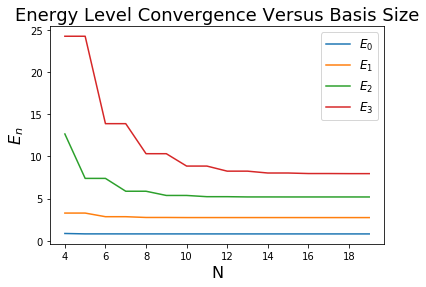

In [ ]:
nrange=range(4,20,1)
darray = np.array([energyvals(n, 1)[:4] for n in nrange])
for i in range(4):
  plt.plot(nrange, darray[:,i])
plt.xlabel('N', fontsize=16)
plt.ylabel('$E_n$', fontsize=16)
plt.legend([r'$E_0$', r'$E_1$', r'$E_2$', r'$E_3$'], fontsize=12)

plt.title('Energy Level Convergence Versus Basis Size', fontsize=18)

# 5) Comparison of our normal harmonic oscillator to the anharmonic oscillator for the first four energy levels

In the code cell below, we plotted our base eigenfunctions with $\lambda$=0 against our anharmonic eigenfunctions with $\lambda$=1 for the first four energy levels. We plotted the probability densities and in the plots below you can see that the anharmonic oscillator is taller and skinnier compared to our normal harmonic oscillator solution. 

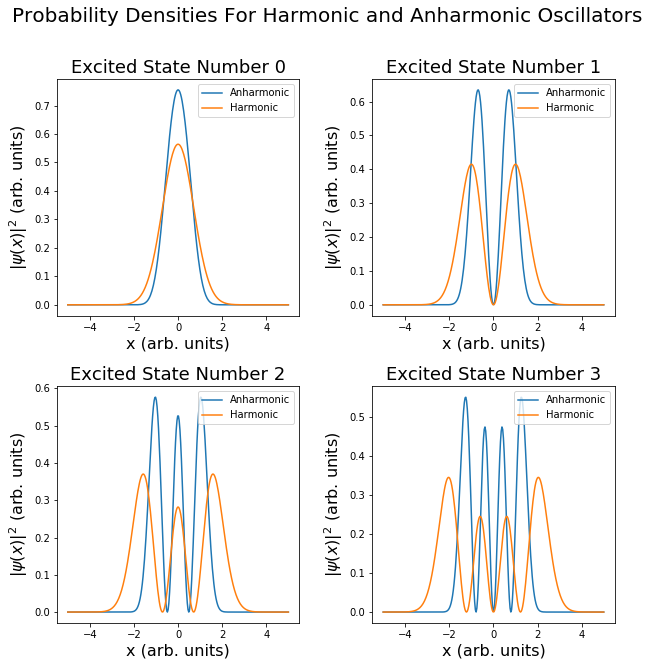

In [ ]:
Hmat = harmonicosc(20, 1)
d,U=hermitian_eigensystem(Hmat,1e-8)

#print(d)
#print(U)

def base_eigenfunction(x, n):
  return (2**n*np.math.factorial(n)*np.sqrt(np.pi))**(-0.5)*np.exp(-x**2/2)*np.polynomial.hermite.hermval(x, np.array([0 for i in range(n)]+[1]))

def anharmonic_eigenfunction(x, n, U):
  coeffs = U[:,n]
  return np.sum(coeffs*np.array([base_eigenfunction(x, i) for i in range(len(coeffs))]))

anharmonic_eigenfunction = np.vectorize(anharmonic_eigenfunction, excluded=[2])

xarr = np.linspace(-5, 5, 300)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

fig.suptitle('Probability Densities For Harmonic and Anharmonic Oscillators', fontsize=20)

for i, axis in enumerate([ax[0,0], ax[0,1], ax[1,0], ax[1,1]]):
  axis.plot(xarr, np.abs(anharmonic_eigenfunction(xarr, i, U))**2)
  axis.plot(xarr, np.abs(base_eigenfunction(xarr, i))**2)
  axis.set_xlabel('x (arb. units)', fontsize=16)
  axis.set_ylabel('$|\psi(x)|^2$ (arb. units)', fontsize=16)
  axis.set_title(f'Excited State Number {i}', fontsize=18)
  axis.legend(['Anharmonic', 'Harmonic'])
  